# Semana 2: Reproducción del baseline

## 1. Preprocesamiento de señales (filtrado, detección de picos R)

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import wfdb
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, ConfusionMatrixDisplay
)


In [8]:
# Detección de picos R en ECG con Python

# Read the file with all records
with open('data/training2017/RECORDS', 'r') as f:
    records = f.read().splitlines()

# Create a function to detect RR intervals
def detect_rr_intervals(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal) + 0.5 * np.std(signal), distance=int(0.2 * fs))
    rr_intervals = np.diff(peaks) / fs
    return rr_intervals

# Create new DataFrame to store RR intervals for all records
rr_intervals_all = []

# Loop through each record and calculate RR intervals
for record_name in records:
    record = wfdb.rdrecord(f'data/training2017/{record_name}')
    signal = record.p_signal[:, 0]
    fs = record.fs
    rr_intervals = detect_rr_intervals(signal, fs)
    for interval in rr_intervals:
        rr_intervals_all.append((record_name, interval))

# Create a DataFrame for all RR intervals
rr_intervals_df = pd.DataFrame(rr_intervals_all, columns=['record', 'RR Interval (s)'])

# Print the summary of RR intervals
print("\nResumen de los intervalos RR para todos los registros:")
print(rr_intervals_df.describe())

# Save the RR intervals to a CSV file
rr_intervals_df.to_csv('data/rr_intervals.csv', index=False)




Resumen de los intervalos RR para todos los registros:
       RR Interval (s)
count    570411.000000
mean          0.476728
std           0.275231
min           0.200000
25%           0.263333
50%           0.413333
75%           0.633333
max          17.906667


## 2. Extracción de características (HRV, estadísticas)

In [5]:
# Calculate features from RR intervals

from scipy import stats

# Read the RR intervals from the CSV file
rr_intervals_df = pd.read_csv('data/rr_intervals.csv')

features = []

for record_name in rr_intervals_df['record'].unique():
    rr = rr_intervals_df[rr_intervals_df['record'] == record_name]['RR Interval (s)'].values
    if len(rr) > 1:
        features.append({
            'record': record_name,
            'mean_rr': np.mean(rr),
            'std_rr': np.std(rr),
            'skew_rr': stats.skew(rr),
            'kurt_rr': stats.kurtosis(rr)
        })

features_df = pd.DataFrame(features)
print(features_df.head())

# Save the features to a CSV file
features_df.to_csv('data/rr_features.csv', index=False)



   record   mean_rr    std_rr   skew_rr   kurt_rr
0  A00001  0.535988  0.224853 -0.261091 -1.533849
1  A00002  0.551235  0.284507  0.421827 -1.255844
2  A00003  0.578220  0.217038 -0.160148 -1.029851
3  A00004  0.475450  0.239311  0.735260 -0.724574
4  A00005  0.435450  0.203122  1.286421  1.256343


## 3. Entrenamiento del modelo baseline (Random Forest)

In [10]:
# Cargar las características y las etiquetas
features_df = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Unir características y etiquetas
data = features_df.merge(labels_df, on='record').dropna()

# Separar variables (X) y etiquetas (y)
X = data[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = data['label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar un modelo base (SVM)
clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train, y_train)



,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## 4. Evaluación simple (train/test o validación cruzada)

Métricas de desempeño del modelo SVM:
Accuracy:  0.5920
F1-Score:  0.4465
Precision: 0.4948
Recall:    0.5920

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       148
           N       0.59      0.99      0.74      1010
           O       0.50      0.01      0.02       491
           ~       0.00      0.00      0.00        57

    accuracy                           0.59      1706
   macro avg       0.27      0.25      0.19      1706
weighted avg       0.49      0.59      0.45      1706



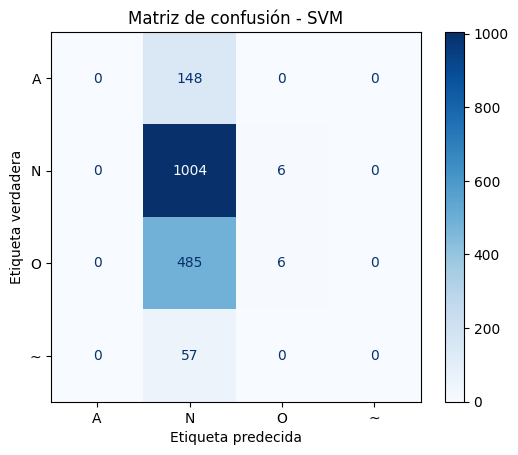

In [13]:
# Predecir sobre el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualización de la matriz de confusión
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM")
disp.ax_.set_xlabel('Etiqueta predecida')
disp.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


## 5. Conclusiones

- Dado que el modelo predice únicamente una etiqueta, debe haber un error en la fase de entrenamiento. Intentaré identificarlo y repararlo.